# Stock Price Prediction Using Deutsche Börse Dataset on SageMaker DeepAR 


## Overview
In this project we use Deutsche Börse Public Dataset consisting of trade data aggregated to one minute intervals from the Xetra trading systems

We obtain the data from public S3 bucket, hosted by Deutsche Börse under AWS Open Data Registry, aggregate the data within a given period, and prepare training, test and validation sets.
We then upload the prepared dat set to our own S3 bucket. This data location is then used with SageMaker provided DeepAR algorithm, to predict future movement of stock prices.

Following diagrams provides an high level overview of the project architecture:
![ML Architecture](../images/architecture.png)

In [1]:
import os
import io
import datetime

import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from pandas.plotting import autocorrelation_plot
from pandas.plotting import scatter_matrix
from jinja2 import Environment, FileSystemLoader

import boto3
import sagemaker

%matplotlib inline

# Define IAM role and session
role = sagemaker.get_execution_role()
session = sagemaker.Session()

s3_data_key = "dbg-stockdata/source"
s3_bucket = session.default_bucket()
processed_filename = "dbg_processed"

source_bucket = "s3://deutsche-boerse-xetra-pds"

## 1. Obtaining Data

Since the DBG dataset is partitioned into separate folders by date, we generate a series of scripts to download the data files, in parallel.

DBG dataset contains trading data beginning June-17, 2017. However we chose to download last 6 months of data, so that the processing time is manageable within the scope of this workshop session.


In [2]:
start_date = datetime.datetime.strptime("2018-04-01", "%Y-%m-%d")
start_date_str = start_date.strftime("%Y-%m-%d")

end_date = datetime.datetime.strptime("2018-10-31", "%Y-%m-%d")
end_date_str = end_date.strftime("%Y-%m-%d")


print(f"Download date range: {start_date_str} - {end_date_str}")


Download date range: 2018-04-01 - 2018-10-31


We store all files in a local folder, prior to pre-processing the data. <br>
After processing, we store the processed data set in another folder, which we'll then upload to an our SageMaker S3 bucket.


In [3]:
download_folder = "../data/download"
processed_folder = "../data/processed"

! mkdir -p {download_folder}
! mkdir -p {processed_folder}

We then generate the download script in script folder and execute it to have the files downloaded.<br>
Running bash script makes the download more reliable than running loops from Pythin runtime.

In [4]:
download_script = download_folder + "/download_files.sh"

dates = list(pd.date_range(start_date_str, end_date_str, freq="D").strftime("%Y-%m-%d"))

values_set = {
    "values_set": [
        {
            "date": date,
            "download_folder": download_folder,
            "source_bucket": source_bucket,
            "success_file": os.path.join(download_folder, date, "success")
        }
        for date in dates
    ]
}

env = Environment(loader=FileSystemLoader("."))

tpl = env.get_template("download_files.j2")

source_code = tpl.render(values_set)

with open(download_script, "w") as f:
    f.write(source_code)

! chmod +x {download_script}

After creating the script, we run the script from shell, using Jupyter magic command.

Downloading data should take about half an hour to an hour to complete depending on the dat range chosen.

In order to avoid this process, you can alternative use the last cell in this notebook to obtain the prepared data from an S3 bucket accompanying this workshop, and load directly to your own S3 bucket.

## 2. Data Preparation

To prepare the data, we collect day wise tading data from separate files, filter out any data falling out of trading window, and not pertaining to common stock trading.

### 2.1. Load Data
As first step we load all csv files in to a single data frame.

Data loading should take about 1-2 hours to complete depending on the instance type you have chosen for your notebook instance.

In [5]:
%%time
!  {download_script}

DBG dataset for date 2018-04-01 already exists
DBG dataset for date 2018-04-02 already exists
DBG dataset for date 2018-04-03 already exists
DBG dataset for date 2018-04-04 already exists
DBG dataset for date 2018-04-05 already exists
DBG dataset for date 2018-04-06 already exists
DBG dataset for date 2018-04-07 already exists
DBG dataset for date 2018-04-08 already exists
DBG dataset for date 2018-04-09 already exists
DBG dataset for date 2018-04-10 already exists
DBG dataset for date 2018-04-11 already exists
DBG dataset for date 2018-04-12 already exists
DBG dataset for date 2018-04-13 already exists
DBG dataset for date 2018-04-14 already exists
DBG dataset for date 2018-04-15 already exists
DBG dataset for date 2018-04-16 already exists
DBG dataset for date 2018-04-17 already exists
DBG dataset for date 2018-04-18 already exists
DBG dataset for date 2018-04-19 already exists
DBG dataset for date 2018-04-20 already exists
DBG dataset for date 2018-04-21 already exists
DBG dataset f

In [6]:
%%time
def convert_datetime(df):
    try: 
        df["CalcTime"] = pd.to_datetime("1900-01-01 " + df["Time"])
        df["CalcDateTime"] = pd.to_datetime(df["Date"] + " " + df["Time"])

    except:
        pass

    return df


def load_csvs(data_folder):
    df = None
    df_initialized = False
    data_dir = data_folder + "/"
    data_subdirs = list(map(lambda date: data_dir + date, dates))
    total_loaded = 0

    for data_subdir in data_subdirs:
        # data_subdir 配下の csv ファイルの Path を取得
        # ファイルサイズが 2000バイト以下のものは分析用のデータから除外
        # 残った Path を sort
        trading_files = sorted(
            list(
                filter(
                    lambda x:os.path.getsize(x)>2000,
                    [
                        os.path.join(data_subdir, x) 
                        for x in os.listdir(data_subdir) 
                        if x.endswith(".csv")
                    ]
                )
            )
        )

        if len(trading_files) > 0:
            print(f"Loading {len(trading_files)} files from {data_subdir}")

            if df_initialized == False:
                frame = [
                    pd.read_csv(f, engine="python", error_bad_lines=False, warn_bad_lines=False) 
                    for f in trading_files
                ]

                df = convert_datetime(pd.concat(frame, ignore_index = True))
                df_initialized = True

            else:
                dfa = convert_datetime(
                    pd.concat(
                        [
                            pd.read_csv(f, engine="python", error_bad_lines=False) 
                            for f in trading_files
                        ],
                        ignore_index = True
                    )
                )

                dft = [df, dfa]
                df = pd.concat(dft, ignore_index = True)

            total_loaded = total_loaded + len(trading_files)

            print(df.shape)

    print(f"Total of {total_loaded} files loaded")

    return df

unprocessed_df = load_csvs(download_folder)

Loading 9 files from ../data/download/2018-04-03
(72417, 16)
Loading 9 files from ../data/download/2018-04-04
(147912, 16)
Loading 9 files from ../data/download/2018-04-05
(215729, 16)
Loading 10 files from ../data/download/2018-04-06
(278634, 16)
Loading 9 files from ../data/download/2018-04-09
(341127, 16)
Loading 9 files from ../data/download/2018-04-10
(404953, 16)
Loading 9 files from ../data/download/2018-04-11
(467602, 16)
Loading 9 files from ../data/download/2018-04-12
(528697, 16)
Loading 10 files from ../data/download/2018-04-13
(589091, 16)
Loading 9 files from ../data/download/2018-04-16
(648125, 16)
Loading 9 files from ../data/download/2018-04-17
(708129, 16)
Loading 9 files from ../data/download/2018-04-18
(770572, 16)
Loading 9 files from ../data/download/2018-04-19
(829425, 16)
Loading 9 files from ../data/download/2018-04-20
(889980, 16)
Loading 9 files from ../data/download/2018-04-23
(950337, 16)
Loading 6 files from ../data/download/2018-04-24
(993162, 16)
Loading

In [7]:
unprocessed_df.head()

,ISIN,Mnemonic,SecurityDesc,SecurityType,Currency,SecurityID,Date,Time,StartPrice,MaxPrice,MinPrice,EndPrice,TradedVolume,NumberOfTrades,CalcTime,CalcDateTime
0,AT0000A0E9W5,SANT,S+T AG (Z.REG.MK.Z.)O.N.,Common stock,EUR,2504159,2018-04-03,07:00,18.03,18.14,18.02,18.14,1408,15,1900-01-01 07:00:00,2018-04-03 07:00:00
1,DE000A0DJ6J9,S92,SMA SOLAR TECHNOL.AG,Common stock,EUR,2504287,2018-04-03,07:00,45.54,45.54,45.34,45.48,858,11,1900-01-01 07:00:00,2018-04-03 07:00:00
2,DE000A0D6554,NDX1,NORDEX SE O.N.,Common stock,EUR,2504290,2018-04-03,07:00,7.04,7.04,7.04,7.04,125,1,1900-01-01 07:00:00,2018-04-03 07:00:00
3,DE000A0Z2ZZ5,FNTN,FREENET AG NA O.N.,Common stock,EUR,2504438,2018-04-03,07:00,24.74,24.74,24.70,24.70,2964,9,1900-01-01 07:00:00,2018-04-03 07:00:00
4,DE000A1EWWW0,ADS,ADIDAS AG NA O.N.,Common stock,EUR,2504471,2018-04-03,07:00,194.95,195.00,194.40,194.90,2213,36,1900-01-01 07:00:00,2018-04-03 07:00:00


### 2.2. Filter records
Next we filter the records pertaining to common stack with trading volumes greater than zero, and within the regular trading hours.
Within the scope of this exercise, we focus our attention to top 100 stocks, by trading volume.

This filtering should take about 1-2 minute to complete depending on the instance type you have chosen for your notebook instance.

In [8]:
%%time
# Filter common stock between trading hours 08:00 and 20:00
# Exclude auctions (those are with TradeVolume == 0)
#Number of stocks to keep : Top 100, by trading volume

num_stocks=100

time_fmt = "%H:%M"

opening_hours_str = "08:00"
closing_hours_str = "20:00"

opening_hours = datetime.datetime.strptime(opening_hours_str, time_fmt)
closing_hours = datetime.datetime.strptime(closing_hours_str, time_fmt)

# 日中の通常取引時間帯に売買があった普通株式？の銘柄を抽出
common_stocks = unprocessed_df.query(
    f"SecurityType == 'Common stock'" 
    f"and TradedVolume > 0 "
    f"and CalcTime >= '{opening_hours}' "
    f"and CalcTime <= '{closing_hours}' "
)

# Sort the stocks in descending order by trading volume
# Mnemonic で grouping を行い, 取引量の多い銘柄上位 num_stocks の数だけ抽出
sort_by_volume = (
    common_stocks[["Mnemonic", "TradedVolume"]]
    .groupby(["Mnemonic"])
    .sum()
    .sort_values(["TradedVolume"], ascending=[0])
    .head(num_stocks)
)

# 上記の処理で抽出した取引量の多い銘柄のみを common_stocks から抽出
stock_symbols = list(sort_by_volume.index.values)
sorted_stocks = common_stocks[common_stocks.Mnemonic.isin(stock_symbols)]
sorted_stocks = sorted_stocks.set_index(["Mnemonic", "CalcDateTime"]).sort_index()
stock_symbols = list(sort_by_volume.index.values)

print(f"sorted_stocks.shape")
print(sorted_stocks.shape)

sorted_stocks.shape
(4167886, 14)
CPU times: user 13.8 s, sys: 2.78 s, total: 16.5 s
Wall time: 15 s


In [9]:
sorted_stocks.head()

ISIN       SecurityDesc  SecurityType  \
Mnemonic CalcDateTime                                                         
1COV     2018-04-03 08:00:00  DE0006062144  COVESTRO AG  O.N.  Common stock   
         2018-04-03 08:01:00  DE0006062144  COVESTRO AG  O.N.  Common stock   
         2018-04-03 08:02:00  DE0006062144  COVESTRO AG  O.N.  Common stock   
         2018-04-03 08:03:00  DE0006062144  COVESTRO AG  O.N.  Common stock   
         2018-04-03 08:04:00  DE0006062144  COVESTRO AG  O.N.  Common stock   

                             Currency  SecurityID        Date   Time  \
Mnemonic CalcDateTime                                                  
1COV     2018-04-03 08:00:00      EUR     2505008  2018-04-03  08:00   
         2018-04-03 08:01:00      EUR     2505008  2018-04-03  08:01   
         2018-04-03 08:02:00      EUR     2505008  2018-04-03  08:02   
         2018-04-03 08:03:00      EUR     2505008  2018-04-03  08:03   
         2018-04-03 08:04:00      EUR     2505008  2018-04-03  08:04   

                              StartPrice  MaxPrice  MinPrice  EndPrice  \
Mnemonic CalcDateTime                                                    
1COV     2018-04-03 08:00:00       78.68     78.68     78.64     78.66   
         2018-04-03 08:01:00       78.70     78.72     78.70     78.70   
         2018-04-03 08:02:00       78.68     78.68     78.58     78.58   
         2018-04-03 08:03:00       78.56     78.60     78.54     78.60   
         2018-04-03 08:04:00       78.58     78.58     78.50     78.58   

                              TradedVolume  NumberOfTrades            CalcTime  
Mnemonic CalcDateTime                                                           
1COV     2018-04-03 08:00:00          1727              22 1900-01-01 08:00:00  
         2018-04-03 08:01:00           668               5 1900-01-01 08:01:00  
         2018-04-03 08:02:00          2118               9 1900-01-01 08:02:00  
         2018-04-03 08:03:00          2325              11 1900-01-01 08:03:00  
         2018-04-03 08:04:00          3468              10 1900-01-01 08:04:00

Check to see how many days' records we imported. If you import all records starting from July-2017, to October-2018, it should contain 326 days' worth of records.

In [10]:
len(sorted(list(sorted_stocks["Date"].unique())))

148

### 2.3. Select features by minute

Next we build a clean data frame containing minute by minute transaction records with the following data points:
- Mnemonic (Stock Ticker Symbol)
- Minimum Price (During the interval)
- Maximum Prixe (During the interval)
- Start Price (At star of the interval)
- End Price (At end of the interval)
- Trading Volume (During the interval)
- Number of Trades (During the interval)

In [11]:
%%time
# Build minute by minute index for trading hours
non_empty_days = sorted(list(sorted_stocks["Date"].unique()))

# 取引のあった日付の一覧から分単位のタイムラインを index とする DataFrame を作成
"""

以下のような DataFrame を作成
non_empty_days = ['2019-10-12', '2019-10-13', ...]
↓
2019-10-12: 08:00:00
2019-10-12: 08:01:00
2019-10-12: 08:02:00
...
2019-10-13: 08:00:00
2019-10-13: 08:01:00
2019-10-13: 08:02:00
...

"""
def build_index(non_empty_days, from_time, to_time):
    date_ranges = []

    for date in non_empty_days:
        yyyy, mm, dd = date.split("-")
        from_hour, from_min = from_time.split(":")
        to_hour, to_min = to_time.split(":")    

        t1 = datetime.datetime(int(yyyy), int(mm), int(dd), int(from_hour),int(from_min),0)
        t2 = datetime.datetime(int(yyyy), int(mm), int(dd), int(to_hour),int(to_min),0) 

        date_ranges.append(
            pd.DataFrame(
                {"OrganizedDateTime": pd.date_range(t1, t2, freq="1Min").values}
            )
        )

    agg = pd.concat(date_ranges, axis=0) 
    agg.index = agg["OrganizedDateTime"]

    return agg

# Prepared data would contain numeric features for all stocks,
# for all days in the interval, for which there were trades (that means excluding weekends and holidays)
# for all minutes from 08:00 until 20:00
# in minutes without trades the prices from the last available minute are carried forward
# trades are filled with zero for such minutes

def basic_stock_features(input_df, mnemonic, time_index):
    stock = input_df.loc[mnemonic].copy()
    stock["HasTrade"] = 1.0    
    stock = stock.reindex(time_index)    

    features = ["MinPrice", "MaxPrice", "EndPrice", "StartPrice"]

    # 分単位で見たとき, その分の間に取引がなく, 価格が null の場合は,
    # 前の分の価格に置き換える
    for f in features:
        stock[f] = stock[f].fillna(method="ffill")       

    features = ["HasTrade", "TradedVolume", "NumberOfTrades"]

    # 分単位で見たとき, その分の間に取引がなく, 値が null の場合は,
    # 「0.0」に置き換える
    for f in features:
        stock[f] = stock[f].fillna(0.0)    

    stock["Mnemonic"] = mnemonic

    selected_features = [
        "Mnemonic", 
        "MinPrice", 
        "MaxPrice", 
        "StartPrice", 
        "EndPrice", 
        "HasTrade", 
        "TradedVolume", 
        "NumberOfTrades"
    ]

    return stock[selected_features]

datetime_index = build_index(
    non_empty_days, 
    opening_hours_str, 
    closing_hours_str
)["OrganizedDateTime"].values

stocks = []

for stock in stock_symbols:
    stock = basic_stock_features(sorted_stocks, stock, datetime_index)
    stocks.append(stock)

prepared = pd.concat(stocks, axis=0)
prepared.insert(0, "Id", range(0, 0 + len(prepared)))
prepared = prepared.reset_index().set_index("Id")

CPU times: user 16.3 s, sys: 2.08 s, total: 18.4 s
Wall time: 10.2 s


In [12]:
prepared.head()

,CalcDateTime,Mnemonic,MinPrice,MaxPrice,StartPrice,EndPrice,HasTrade,TradedVolume,NumberOfTrades
Id,,,,,,,,,
0,2018-04-03 08:00:00,SNH,NaN,NaN,NaN,NaN,0.0,0.0,0.0
1,2018-04-03 08:01:00,SNH,0.2266,0.2272,0.2272,0.2266,1.0,40219.0,6.0
2,2018-04-03 08:02:00,SNH,0.2266,0.2270,0.2266,0.2270,1.0,12347.0,4.0
3,2018-04-03 08:03:00,SNH,0.2270,0.2272,0.2270,0.2272,1.0,45498.0,7.0
4,2018-04-03 08:04:00,SNH,0.2275,0.2290,0.2275,0.2289,1.0,247632.0,10.0


### 2.4. Save processed data
Finally we save the processed data and upload to our SageMaker S3 Bucket.<br>
Source data, as downloaded from DBG dataset includes minute by minute details of price movement and trading numbers and volumes for the stocks. However, in practice, we might be interested in time series at various aggregation level, in order to do more effective hourly, daily or weekly predictions.

Therefore we resample the data at various interval levels. First we define a resampling function that is able to resample various metrices for the aggregation levels.<br>
For example, at a certain interval level, we are interested in:<br>
- Last record for the End Price
- First record for the Start Price
- Minimum of all records for Min Price
- Maximum of all records for Max Price
- Total of all records for Number of Trades and Traded Volume

In [13]:
intervals = ["M", "W", "D", "H"]

def resample_data(df, interval = None, mnemonics=None, metrics=None):
    # resampleing の際に参照する銘柄を決定
    # 銘柄の指定がある（ mnemonics != None ）
    # => mnemonics をそのまま採用
    # 銘柄の指定がない（ mnemonics == None ）
    # => df の Mnemonic にある銘柄を採用
    if mnemonics is None:
        mnemonics = list(df.Mnemonic.unique())

    # resampleing の際に参照する column を決定
    # column の指定がある（ metrics != None ）
    # => metrics をそのまま採用
    # column の指定がない（ metrics == None ）
    # => df.columns.values で取得できる column を採用
    if metrics is None:
        metrics = list(df.columns.values)

    # 不要な column を削除
    if "Mnemonic" in metrics:
        metrics.remove("Mnemonic")
    if "HasTrade" in metrics:
        metrics.remove("HasTrade")

    columns = list(df.columns.values)

    if "CalcDateTime" not in columns:        
        df["CalcDateTime"] = pd.to_datetime(df["CalcDateTime"])

    if interval is None or not isinstance(interval, str) or interval not in intervals:
        raise ValueError(f"Interval not supported, must be one of : {intervals}")

    resampeled_frames = []         

    for mnemonic in mnemonics:
        print(f"Resampling {mnemonic} records for interval - {interval}")

        selected = df.query(f"Mnemonic == {mnemonic}").copy()
        selected.index = selected["CalcDateTime"]
        selected = selected.sort_index()

        resampled = pd.DataFrame()   

        # resampling
        for metric in metrics:            
            if metric == "StartPrice":
                resampled[metric] = selected[metric].resample(interval).first()
            elif metric == "EndPrice":
                resampled[metric] = selected[metric].resample(interval).last()                   
            elif metric == "MinPrice":
                resampled[metric] = selected[metric].resample(interval).min()                                 
            elif metric == "MaxPrice":
                resampled[metric] = selected[metric].resample(interval).max()                                  
            elif metric == "TradedVolume" or metric == "NumberOfTrades" :
                resampled[metric] = selected[metric].resample(interval).sum()                               
            else:
                pass

        resampled_columns = ["Mnemonic"]

        for col in list(resampled.columns.values):
            resampled_columns.append(col)

        resampled["Mnemonic"] = mnemonic
        resampled = resampled[resampled_columns]  
        resampled.dropna(inplace = True)
        resampeled_frames.append(resampled)

    resampeleds = pd.concat(resampeled_frames)

    return resampeleds

Next we do a resampling for the following intervals and upload the file to an appropriate S3 location directly, saving local disk space:
- Month
- Week
- Day
- Hour

Resampling of the time series data at four different interval levels should take about 10 to 20 minutes to complete, depending on the instance type you have chosen for your notebook instance.

Note that this causes gaps in time series. However SageMaker DeepAR algorithm is designed to work with time series with gaps.

In [14]:
%%time
for interval in intervals:
    rescaled_series = resample_data(prepared, interval)
    csv_buffer = io.StringIO()
    rescaled_series.to_csv(csv_buffer)

    s3_resource = boto3.resource("s3")
    s3_resource.Object(
        s3_bucket, 
        f"{s3_data_key}/{interval}/resampled_stockdata.csv"
    ).put(Body=csv_buffer.getvalue())


Resampling SNH records for interval - M
Resampling DBK records for interval - M
Resampling EOAN records for interval - M
Resampling DTE records for interval - M
Resampling CBK records for interval - M
Resampling IFX records for interval - M
Resampling LHA records for interval - M
Resampling RWE records for interval - M
Resampling DPW records for interval - M
Resampling DAI records for interval - M
Resampling BAYN records for interval - M
Resampling TKA records for interval - M
Resampling AT1 records for interval - M
Resampling O2D records for interval - M
Resampling BAS records for interval - M
Resampling SAP records for interval - M
Resampling SIE records for interval - M
Resampling SVAB records for interval - M
Resampling BMW records for interval - M
Resampling CEC records for interval - M
Resampling FRE records for interval - M
Resampling VOW3 records for interval - M
Resampling HDD records for interval - M
Resampling AIXA records for interval - M
Resampling EVT records for interval

Having the prepared data saved to an S3 bucket not only allows us to save some space in lcoal machine, but also helps when starting training job using SageMaker.<br>
Since reading from S3 is optimized for high speed, when you are using an EC2 instance, which is what a SageMaker Notebook instance runs on, it makes sense to just load the data directly from S3, as and when needed.<br><br>
Also, since SageMaker notebook instances come with only 5GB of Elastic Block Storage (to remain cost efficient), it is advisable to keep the device storage space clean, when not used.<br><br>
Therefore, we delete the raw data files locally, to conserve storage space on notebook instance.


In [15]:
# Remove the download folder
# !rm -rf {download_folder}

# Reset the data frames loaded in memory
rescaled_series = None    
prepared = None
unprocessed_df = None

### 2.5. Alternatively - Load resampled data for workshop

Since obtaining raw data from source S3 buckets maintained by Deutsche Börse, filtering, resampling and uploading to SageMaker S3 bucket can take upward of two hours, within the time limit of this workshop you could obtain cleaned data as hosted directly from S3 buckets specifically maintained for this workshop.


In [16]:
import os
import io
import datetime

import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from pandas.plotting import autocorrelation_plot
from pandas.plotting import scatter_matrix

import boto3
import sagemaker

%matplotlib inline

# Define IAM role and session
role = sagemaker.get_execution_role()
session = sagemaker.Session()

s3_data_key = "dbg-stockdata/source"
s3_bucket = session.default_bucket()
processed_filename = "dbg_processed"


workshop_bucket = "samples-aws-hands-on-ml/amazon-sagemaker-stock-prediction"
intervals = ["M", "W", "D", "H"]
datafilename = "resampled_stockdata.csv"

# 目的がよく分からない...
# for interval in intervals:
#     !aws s3 cp s3://{workshop_bucket}/{s3_data_key}/{interval}/{datafilename} s3://{s3_bucket}/{s3_data_key}/{interval}/{datafilename}


### 2.6. Validate Data Load from S3

Before moving on, we want to validate data by downloading from the location on S3 that we just saved, and run some quick introspection to develop an intuition about the nature of metrices and their possible influence on stock price movement.<br>
For our preliminary analysis, we choose to load and investigate data with daily interval.

In [17]:
def load_resampled_from_s3(interval, bucket, s3_data_key):
    s3 = boto3.client("s3")

    obj = s3.get_object(
        Bucket=bucket, 
        Key=f"{s3_data_key}/{interval}/resampled_stockdata.csv"
    )

    loaded = pd.read_csv(io.BytesIO(obj["Body"].read()), parse_dates=True)

    mnemonics = list(loaded.Mnemonic.unique())
 
    return loaded, mnemonics

In [18]:
%%time
interval = "H"
stockdata, stocksymbols = load_resampled_from_s3(interval, s3_bucket, s3_data_key)


CPU times: user 216 ms, sys: 26.7 ms, total: 242 ms
Wall time: 369 ms


In [19]:
stockdata.head()

,CalcDateTime,Mnemonic,MinPrice,MaxPrice,StartPrice,EndPrice,TradedVolume,NumberOfTrades
0,2018-04-03 08:00:00,SNH,0.2266,0.2319,0.2272,0.2293,1468670.0,165.0
1,2018-04-03 09:00:00,SNH,0.2257,0.2307,0.2302,0.2289,1063894.0,195.0
2,2018-04-03 10:00:00,SNH,0.2287,0.2307,0.2289,0.2300,565207.0,92.0
3,2018-04-03 11:00:00,SNH,0.2286,0.2311,0.2296,0.2309,1530769.0,218.0
4,2018-04-03 12:00:00,SNH,0.2299,0.2327,0.2301,0.2318,737223.0,129.0


### Data exploration
At the end, we do a quick check on the data, and plot some series to develop an intuition of what the data looks like.

In [20]:
# use bigger graphs
matplotlib.rcParams["figure.figsize"] = (25, 17)

def timeseries_plot(mnemonics, metrics, data=None, interval = None, bucket = None, s3_key = None):
    if (data is None 
        and interval is not None 
        and bucket is not None 
        and s3_key is not None):
        data, symbols = load_resampled_from_s3(interval, bucket, s3_key)      

    columns = list(data.columns)

    ax = None

    for mnemonic in mnemonics:
        selected = data.query(f"Mnemonic == {mnemonic}").copy()
        selected.index = selected['CalcDateTime']
        selected = selected.sort_index()

        # plot する上で不要となる column を削除
        for column in columns:
            if (column != "CalcDateTime" 
                and column != "Mnemonic" 
                and column not in metrics):
                selected = selected.drop(column, axis=1)

        selected_columns = list(selected.columns)

        for i, column in enumerate(selected_columns):
            selected_columns[i] = f"{mnemonic}-{column}"

        selected.columns = selected_columns

        ax = selected.plot(ax=ax)

Let's plot ending price for 3 automobile companies - BMW, Daimler, Porsche, Volkwagen

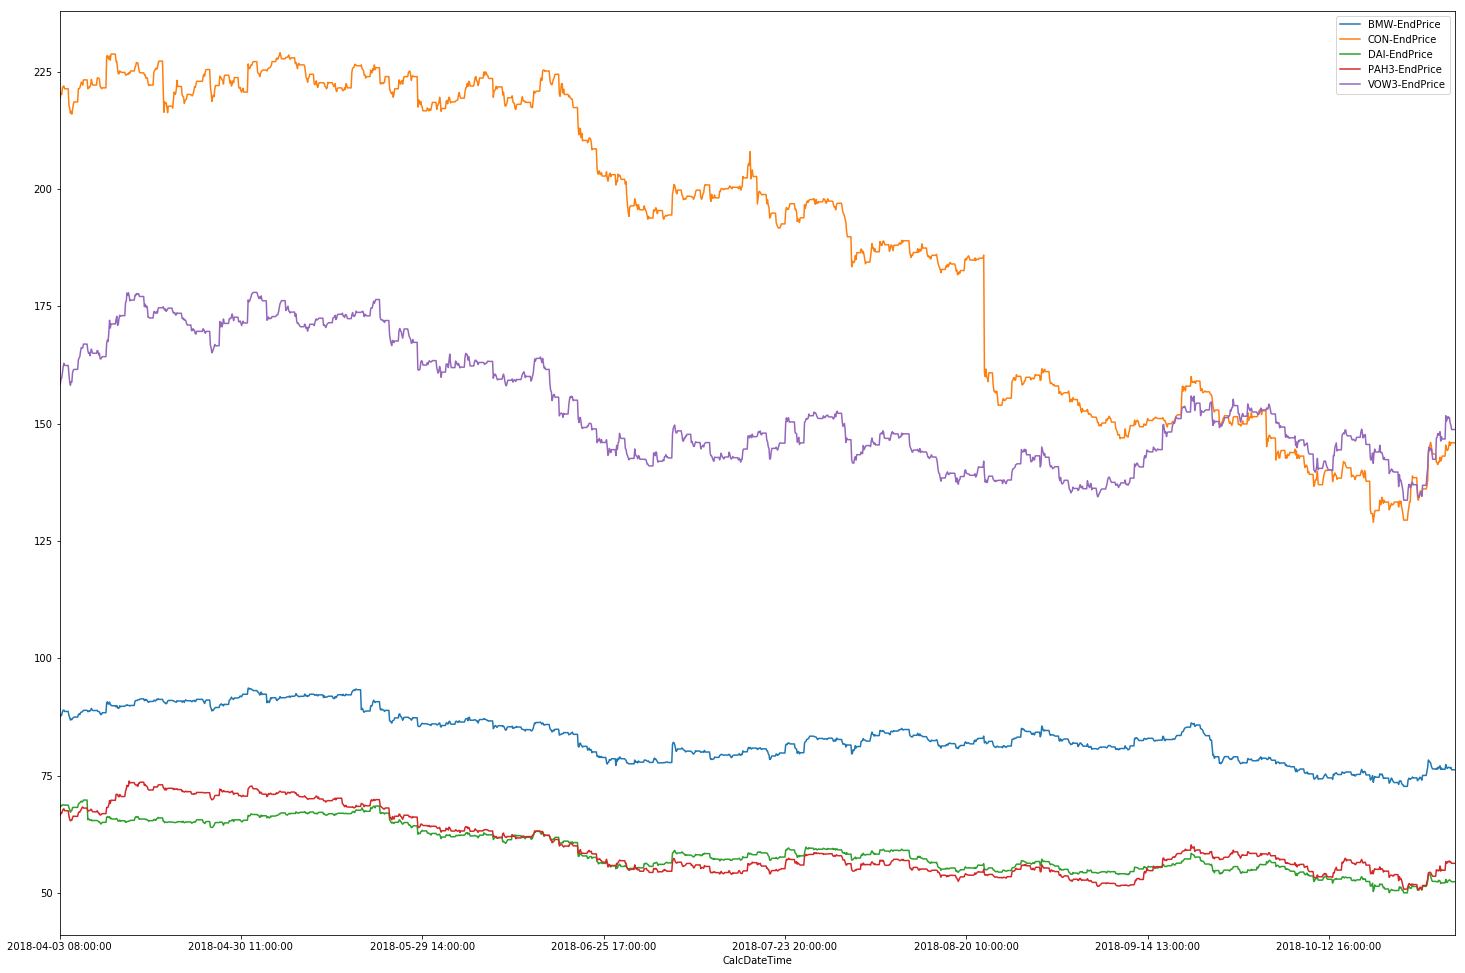

In [21]:
timeseries_plot(
    ["BMW", "CON", "DAI", "PAH3", "VOW3"], 
    ["EndPrice"], 
    stockdata
)

Observe here since the four stocks we chose to display are all automobile companies, their movements show very similar pattern.

We can also choose to display these stocks at lower resolution, such as at weekly interval, and still be able to observe the same patter.

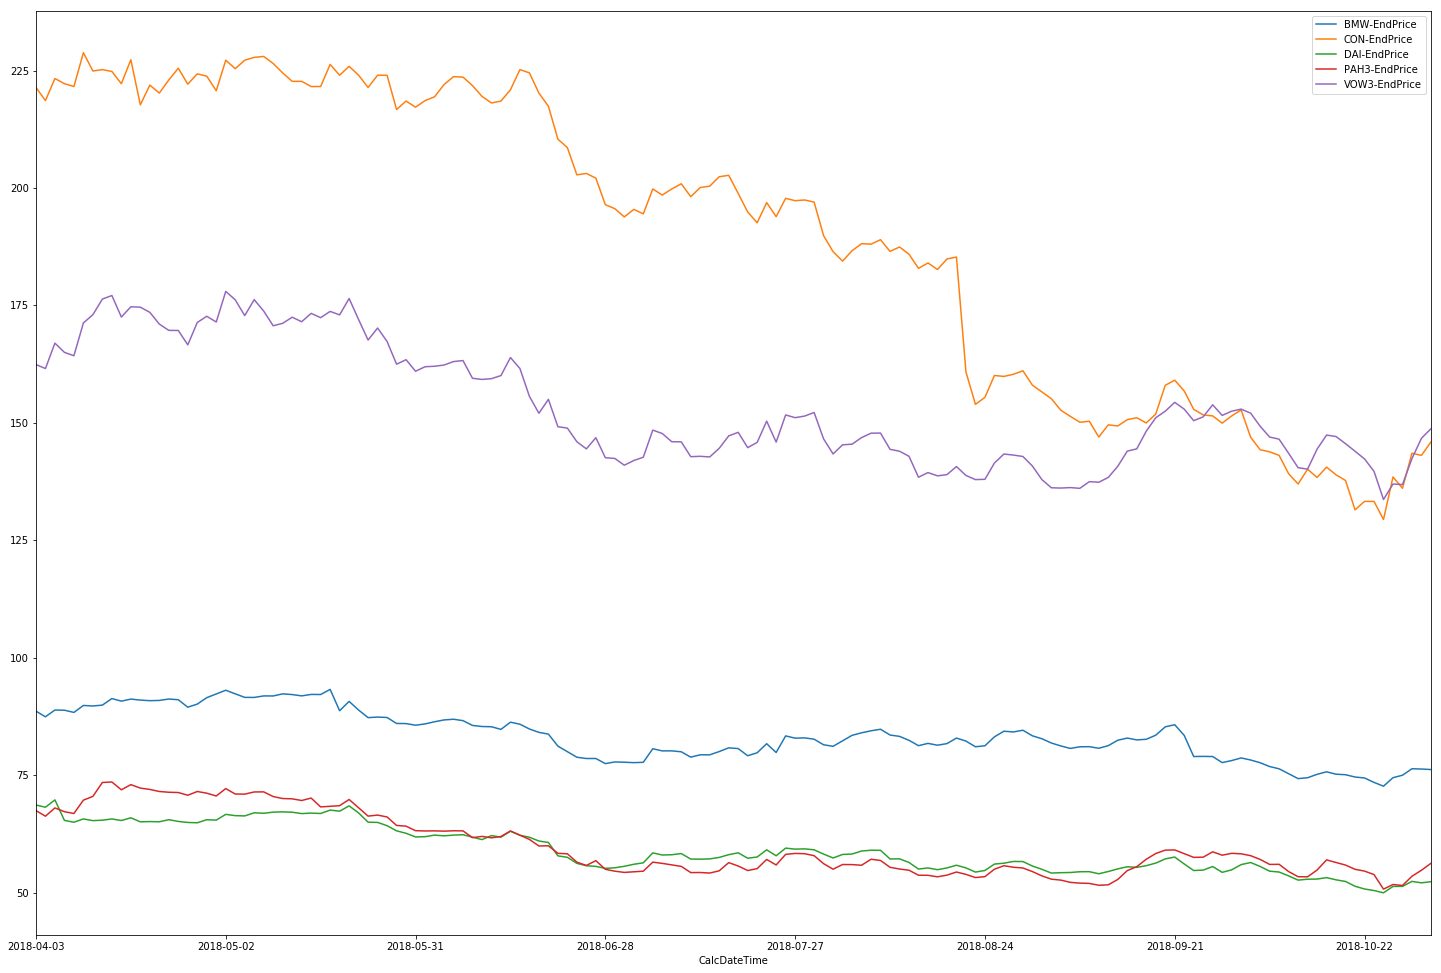

In [22]:
timeseries_plot(
    ["BMW", "CON", "DAI", "PAH3", "VOW3"], 
    ["EndPrice"], 
    interval = "D", 
    bucket = s3_bucket, 
    s3_key = s3_data_key
)


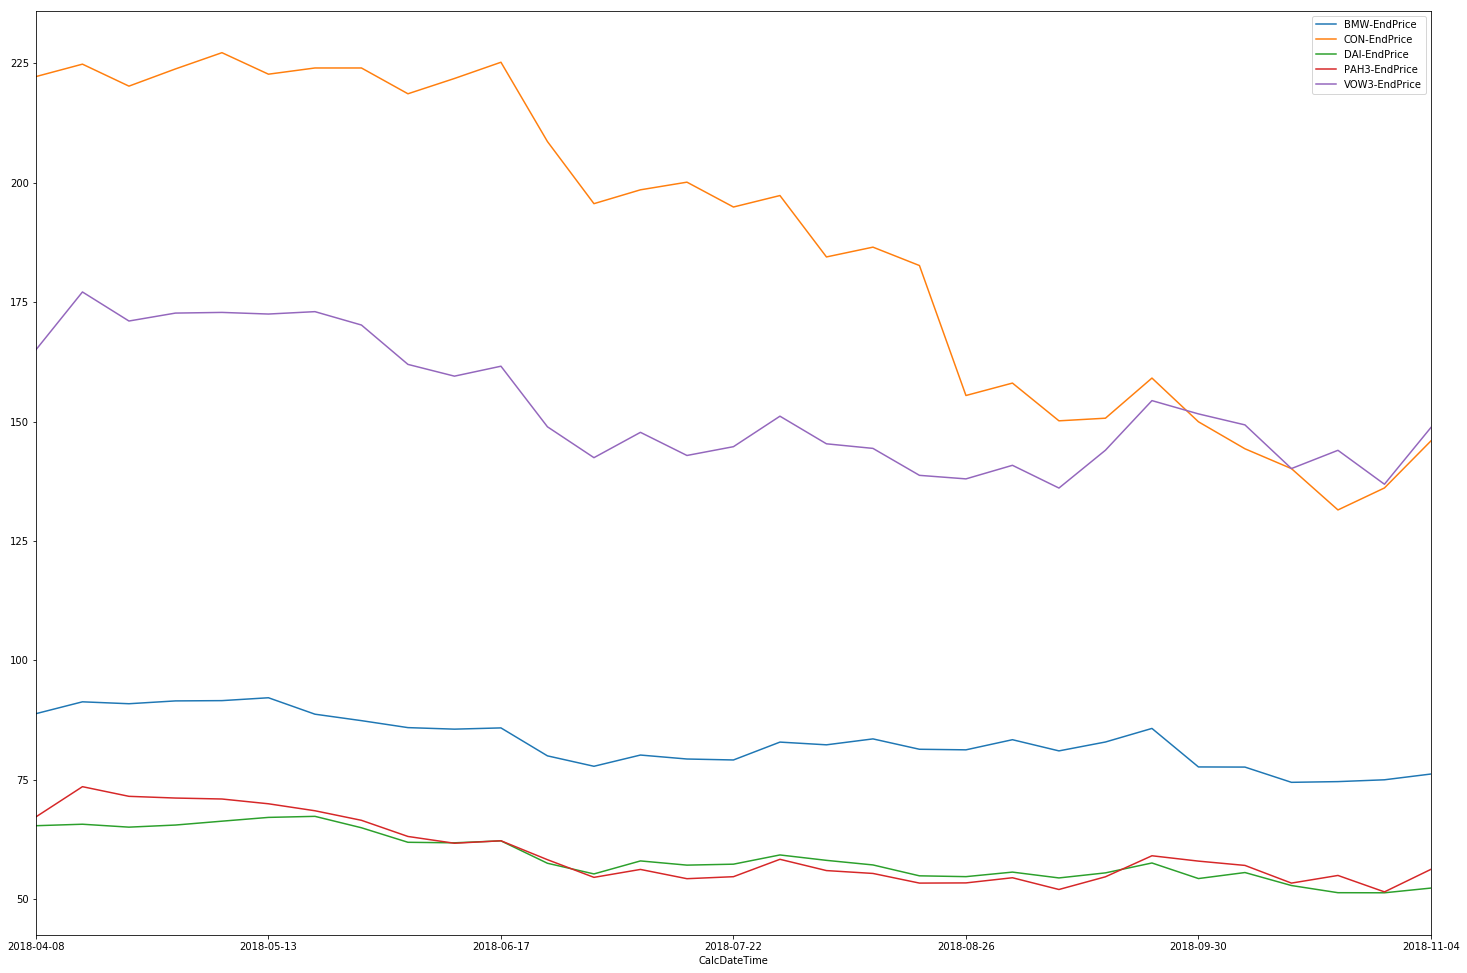

In [23]:
timeseries_plot(
    ["BMW", "CON", "DAI", "PAH3", "VOW3"], 
    ["EndPrice"], 
    interval = "W", 
    bucket = s3_bucket, 
    s3_key = s3_data_key
)


Now, in order to develop an intuition on how different time series for a single stock might influence each other,  we plot some metrices alongside each other, that might be somehow related, for a sample stock, in this case we just used "BMW".


Since the data set gives minute by minute observation of values, it might clutter the visual plot when it comes to understanding the patterns in the data, use data resampled at higher interval rate, such as daily or weekly.<br>


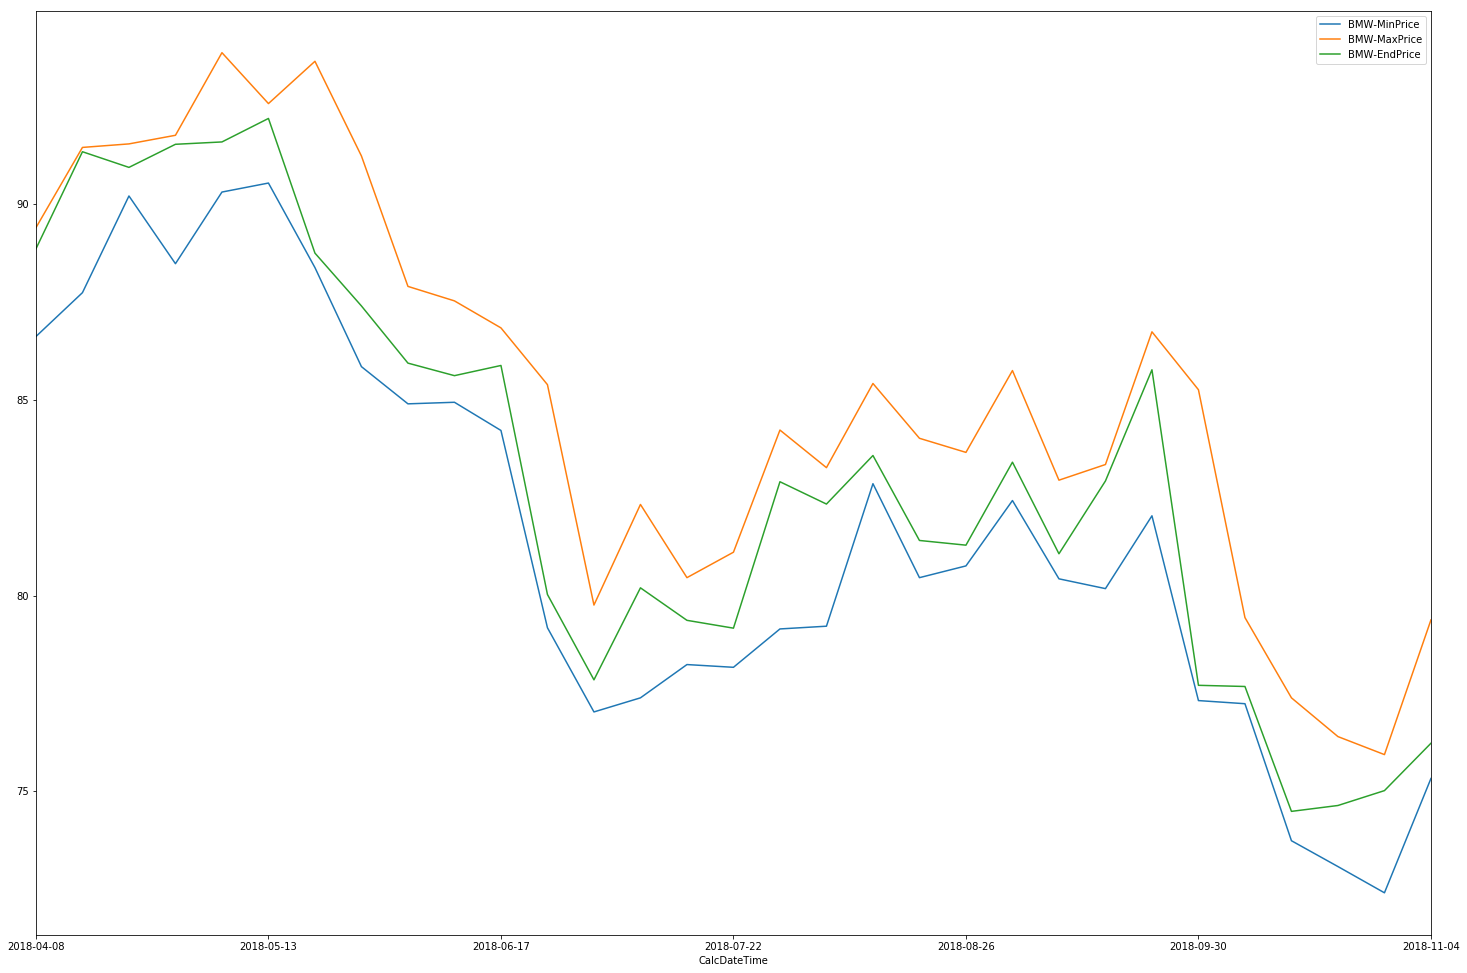

In [24]:
timeseries_plot(
    ["BMW"], 
    ["EndPrice", "MinPrice", "MaxPrice"], 
    interval = "W", 
    bucket = s3_bucket, 
    s3_key = s3_data_key
)


### Observation 1

We can observed from the graph above:

- When there is a downward trend, the `EndPrice` is closer to the `MinPrice`, than to the `MaxPrice`
- When there is an upward trend, the `EndPrice` is closer to `MaxPrice` than to the `MinPrice`

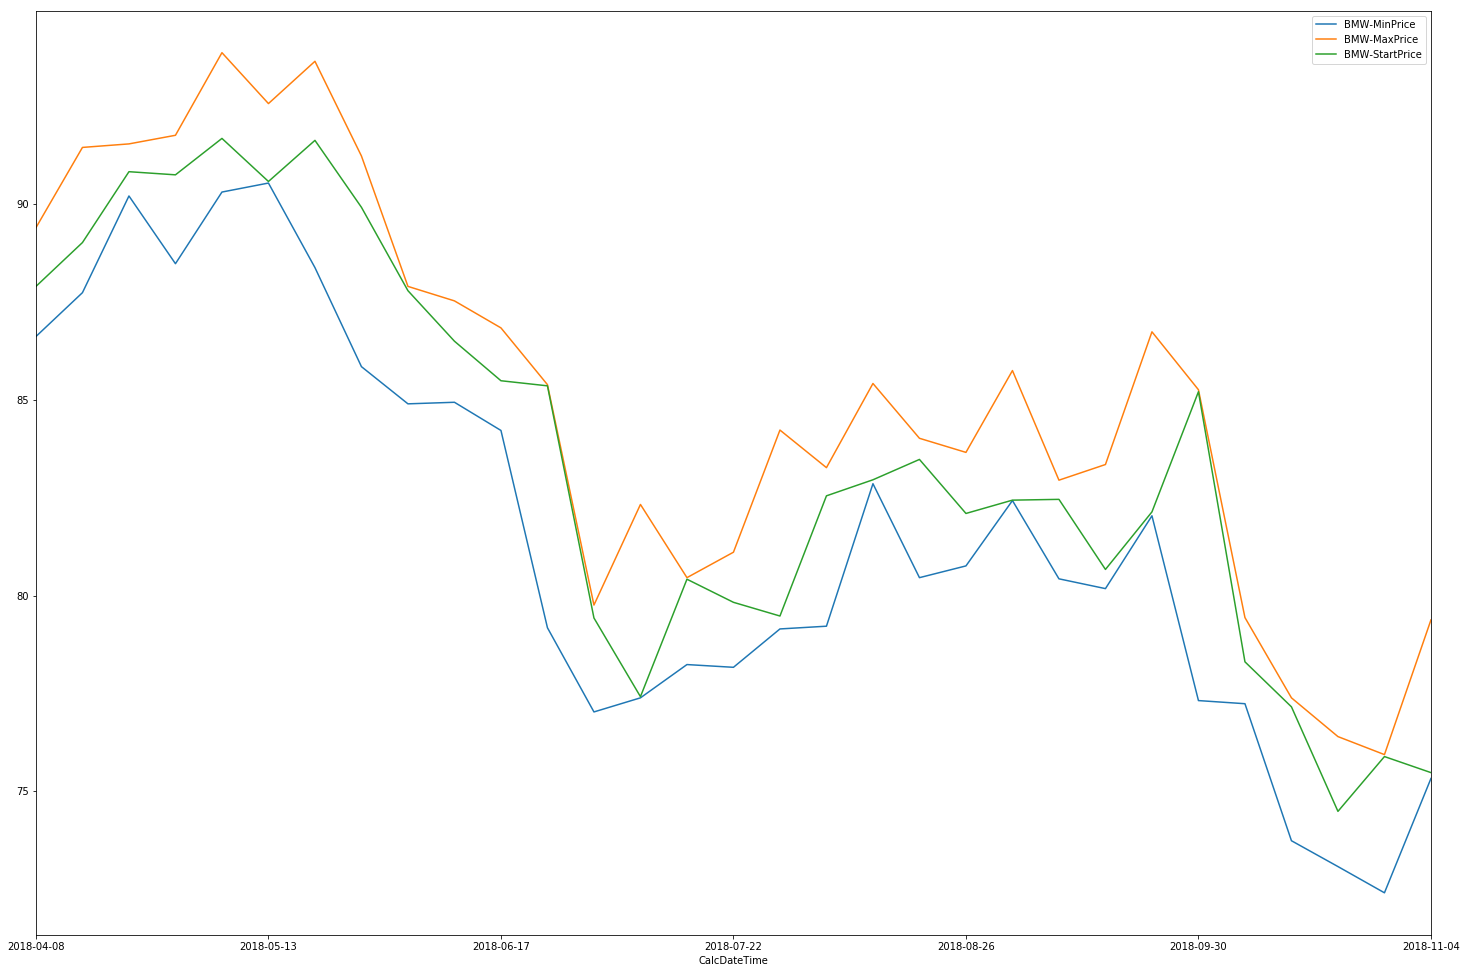

In [25]:
timeseries_plot(
    ["BMW"], 
    ["StartPrice", "MinPrice", "MaxPrice"], 
    interval = "W", 
    bucket = s3_bucket, 
    s3_key = s3_data_key
)


### Observation 2
Similar (and correlated) behavior is true for the `StartPrice`:

- When there is a downward trend, the `StartPrice` is closer to the `MaxPrice`, than to the `MinPrice`
- When there is an upward trend, the `StartPrice` is closer to `MinPrice` than to the `MaxPrice`

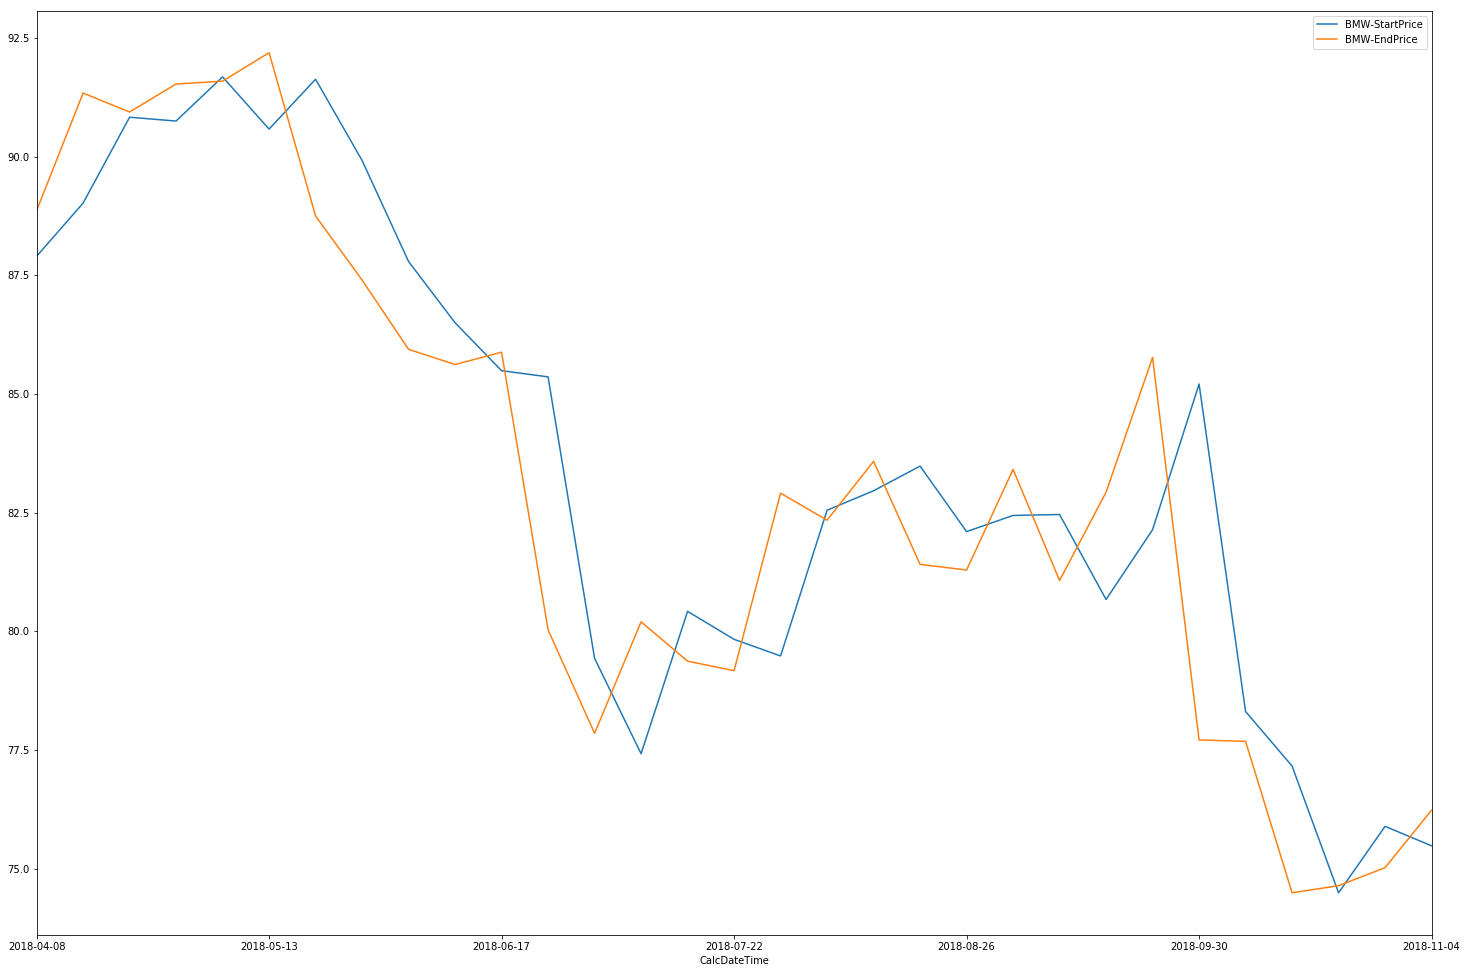

In [26]:
timeseries_plot(
    ["BMW"], 
    ["StartPrice", "EndPrice"], 
    interval = "W", 
    bucket = s3_bucket, 
    s3_key = s3_data_key
)


### Observation 3

Another observation that can be made is that:
- when the trend is upwards, `EndPrice` is above `StartPrice`
- when the trend is downwars, `EndPrice` is below `StartPrice`
    
Therefore: if the lines of `EndPrice` and `StartPrice` cross, one could expect trend reversal.
(Of course one needs to account for the variance, and false positives)

With these observations, we develop intuition that behaviour of the various metrices present in the data might have a correlation with future movement of the time series.<br>


In the next step we apply Deep Neural Networks based Machine Learning techniques to try and find the correlation and hopefully be able to predict future movement, with certain confidence level.